### Note book Two

Compare the survey results for specific items indentified during shoreline surveillance of Lake Geneva. Group survey results in time by Winter, Spring, Summer or Fall, by body of water and municipality.

__Research question:__

_Does the data indicate that shoreline litter densities are seasonal? If so describe the relationship._

#### Contents

1. Automating some things
2. Making a MlwCode class  
3. Dealing with time
4. Grouping by season
5. Plot grouped by season and code


### Setting up

Make sure you are running the same packages as this notebook. There is a requirements.txt file for the virutal environment in the [repo](https://github.com/hammerdirt/SWE_2019.git). 

#### Imports

No changes form note book one

In [1]:
import numpy as np
import json
import csv
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import os
import matplotlib.dates as mdates
from matplotlib import colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
# making the file structure
# if you changed the file structure then this function will be problematic


folders = ["Data", "Charts", "Utilities"]
here = os.getcwd()
# never comment this out -- it is used to save output
def make_folders():
    my_folders = {}
    for folder in folders:
        place = here +"/"+ folder
        my_folders[folder] = place
    return my_folders
my_folders = make_folders()

### Making the code class

Gather and compute details for the MLW Codes in a class. 

#### Utility functions

In [3]:
# nothing fancy, jsut storing the data we used in Notebook one in a class object.

# variables
variable_names=["beach_info", "get_toys", "get_sheeting"]
end_points = [
    "http://mwshovel.pythonanywhere.com/dirt/beaches/Lac-L%C3%A9man/",
    "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G32",
    "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/G67",    
]

def get_the_data(variable_names,end_points):
    data = {}
    for i, name in enumerate(variable_names):
        data[name] = requests.get(end_points[i]).json()
    return data
# make a pieces per meter value for each observation
def get_pieces_per_meter(a_list_of_objects):
    new_list_of_objects = []
    the_keys = list(a_list_of_objects.keys())    
    for this_key in the_keys:
        new_list = a_list_of_objects[this_key]
        for the_object in new_list:
            new_object = the_object
            new_object["pcs_m"] = np.round(new_object["quantity"]/new_object["length"], 3)
            new_list_of_objects.append(new_object)
    return new_list_of_objects
# make a summary of the data 
def make_summary(data):
    results = {}
    pcs_m = []
    for result in data:
        pcs_m.append(result["pcs_m"])
    results["the_min"] = np.min(pcs_m)
    results["the_max"] = np.max(pcs_m)
    results["the_median"] = np.median(pcs_m)
    results["the_average"] = np.mean(pcs_m)
    results["twenty_fifth"] = np.percentile(pcs_m, 25)
    results["seventy_fifth"] =  np.percentile(pcs_m, 75)
    results["no_samples"] = len(pcs_m)
    results["last_sample"] = max([x["date"] for x in data])
    results["first_sample"] = min([x["date"] for x in data])
    return results
# make time value pairts
def time_value_pairs(aList):
    myPairs = [[result['date'], result['pcs_m']] for result in aList]
    return myPairs  
    

#### Wrting the class

In [4]:
code = "G32"
common_name = ["toys_data"]
end_point = "http://mwshovel.pythonanywhere.com/dirt/codes/Lac-L%C3%A9man/"

class MlWCodes():
    def __init__(self, code, common_names, end_points):
        self.code = code
        self.data = get_pieces_per_meter(get_the_data(common_names,end_points))
        self.time_value = time_value_pairs(self.data)
        self.summary = make_summary(self.data)
        
    
toys = MlWCodes(code=code, common_names=['toys_data'], end_points=[end_point + 'G32'])

# Additional classes
polystyrene = MlWCodes(code=code, common_names=['polystyrene_data'], end_points=[end_point + 'G82'])
plastic_sheeting = MlWCodes(code=code, common_names=['plastic-sheeting_data'], end_points=[end_point + 'G67'])

#### Using the class

In [5]:
type(toys.summary)

dict

In [6]:
# get the summary of data for toys
toys.summary

{'the_min': 0.012,
 'the_max': 2.222,
 'the_median': 0.063,
 'the_average': 0.12757894736842101,
 'twenty_fifth': 0.027750000000000004,
 'seventy_fifth': 0.125,
 'no_samples': 76,
 'last_sample': '2019-10-10',
 'first_sample': '2015-11-23'}

In [7]:
# create a panda dataframe of the summary to have a nice looking table
toys_df = pd.DataFrame(toys.summary, index=[0])
toys_df = toys_df.join(pd.DataFrame({'code_id': ['G32']}))
toys_df

,the_min,the_max,the_median,the_average,twenty_fifth,seventy_fifth,no_samples,last_sample,first_sample,code_id
0,0.012,2.222,0.063,0.127579,0.02775,0.125,76,2019-10-10,2015-11-23,G32


In [8]:
plastic_sheeting = pd.DataFrame(plastic_sheeting.summary, index=[0])
plastic_sheeting = plastic_sheeting.join(pd.DataFrame({'code_id': ['G67']}))
plastic_sheeting

,the_min,the_max,the_median,the_average,twenty_fifth,seventy_fifth,no_samples,last_sample,first_sample,code_id
0,0.014,6.1,0.2355,0.566918,0.095,0.54925,110,2019-10-10,2015-11-24,G67


In [9]:
# join the summary of our two items of interest into one table
df = toys_df.append(plastic_sheeting , ignore_index=True)
df

,the_min,the_max,the_median,the_average,twenty_fifth,seventy_fifth,no_samples,last_sample,first_sample,code_id
0,0.012,2.222,0.0630,0.127579,0.02775,0.12500,76,2019-10-10,2015-11-23,G32
1,0.014,6.100,0.2355,0.566918,0.09500,0.54925,110,2019-10-10,2015-11-24,G67


### Searching, grouping and sorting by date or date range

1. Get the results for one survey day at a location
2. Group survey results by date range

The MLWCodes class includes an array of results in pcs/m per survey __MLWCodes.time_value__ or the pieces per survey is in __MLWCodes.data__.

First thing is to get the latest sample by the SWE group and take a look at those results.

####  Get the results for one survey from the data

1. Specify date and location
2. Compare the results of that sample to the sample population

In [10]:
# call the function to get data for a given date
all_the_data = get_the_data(["pierrettes"], ["http://mwshovel.pythonanywhere.com/dirt/codes/Parc-des-Pierrettes"])

# define a method that accpets the data, a key and and the required date in integer form
def get_the_date(all_the_data, key, year, month, day):
    the_results = all_the_data[key]
    my_date_string = '{year}-{month}-{day}'.format(year=year, month=month, day=day)
    i_want_these = [item for item in the_results if item['date'] == my_date_string]
    return i_want_these
    
the_latest_inventory = get_the_date(all_the_data, "pierrettes", 2019,10,10)

In [11]:
# call the function to get data for any date
all_the_data = get_the_data(["pierrettes"], ["http://mwshovel.pythonanywhere.com/dirt/codes/Parc-des-Pierrettes"])

# define a method that accpets the data, a key and and the required date in integer form
def get_all_date(all_the_data, key):
    the_results = all_the_data[key]
    i_want_these = [item for item in the_results]
    return i_want_these
    
all_inventory_pierrettes = get_all_date(all_the_data, "pierrettes")

In [12]:
# python will not accept a number starting with 3, and the date 2017-10-5 does not exists so the 5 has to be passed as a string '05'
the_first_inventory = get_the_date(all_the_data, "pierrettes", 2016,10,13)
the_second_inventory = get_the_date(all_the_data, "pierrettes", 2017,10,'05')

In [13]:
# turn the list into a panda dataframe
pierretes_all = pd.DataFrame(all_inventory_pierrettes)
pierretes_all

,location_id,date,code_id,length,quantity,project_id,owner
0,Parc-des-Pierrettes,2016-10-13,G10,48,1,MCBP,mwshovel
1,Parc-des-Pierrettes,2016-10-13,G100,48,38,MCBP,mwshovel
2,Parc-des-Pierrettes,2016-10-13,G125,48,2,MCBP,mwshovel
3,Parc-des-Pierrettes,2016-10-13,G142,48,1,MCBP,mwshovel
4,Parc-des-Pierrettes,2016-10-13,G145,48,4,MCBP,mwshovel
...,...,...,...,...,...,...,...
83,Parc-des-Pierrettes,2019-10-10,G99,30,1,tiger-duck,mwshovel
84,Parc-des-Pierrettes,2019-10-10,G100,30,9,tiger-duck,mwshovel
85,Parc-des-Pierrettes,2019-10-10,G178,30,1,tiger-duck,mwshovel
86,Parc-des-Pierrettes,2019-10-10,G19,30,1,tiger-duck,mwshovel


In [14]:
# the dates for this beach are:
pierretes_all['date'].unique()

array(['2016-10-13', '2017-10-05', '2019-10-10'], dtype=object)

In [15]:
# find a specific object for any date on this beach
pierretes_all.loc[pierretes_all['code_id'] == 'G32']

,location_id,date,code_id,length,quantity,project_id,owner
20,Parc-des-Pierrettes,2016-10-13,G32,48,6,MCBP,mwshovel
52,Parc-des-Pierrettes,2017-10-05,G32,42,2,MCBP,mwshovel
76,Parc-des-Pierrettes,2019-10-10,G32,30,3,tiger-duck,mwshovel


In [16]:
# find a specific object for any date on this beach
pierretes_all.loc[pierretes_all['code_id'] == 'G67']

,location_id,date,code_id,length,quantity,project_id,owner
25,Parc-des-Pierrettes,2016-10-13,G67,48,4,MCBP,mwshovel
70,Parc-des-Pierrettes,2019-10-10,G67,30,14,tiger-duck,mwshovel


##### get the total number found, the pieces per meter and the number of categories

In [17]:
def get_some_stats(aList):
    the_total = 0
    pcs_m = 0
    the_most = 0
    the_most_object = ''
    number_of_categories = len(aList)
    for result in aList:
        the_total += result["quantity"]
        pcs_m += result['quantity']/result['length']
        if result["quantity"] > the_most:
            the_most = result['quantity']
            the_most_object = result['code_id']
    return {'pcs-m':pcs_m, 'the_total': the_total, 'categories':number_of_categories, 'the_max':the_most, 'the_max_object':the_most_object}

##### Research questions:

1. How does the pcs_m value found on that day compare to the results for the whole lake?
2. What was the probability of finding that value? (given past results)
3. Does the_max_object fall in the top ten of the whole lake?
4. How does the value for pcs-m toys compare to the previous results?

##### __Given the previous results, do you feel the latest survey results were predictable? How would you go about predicting values in the future?__


In [18]:
get_some_stats(the_latest_inventory)

{'pcs-m': 6.366666666666665,
 'the_total': 191,
 'categories': 28,
 'the_max': 70,
 'the_max_object': 'G82'}

In [19]:
# get some stats for the two first dates in pierrettes
get_some_stats(the_first_inventory), get_some_stats(the_second_inventory)

({'pcs-m': 14.437499999999998,
  'the_total': 693,
  'categories': 35,
  'the_max': 267,
  'the_max_object': 'G82'},
 {'pcs-m': 6.1428571428571415,
  'the_total': 258,
  'categories': 25,
  'the_max': 57,
  'the_max_object': 'G27'})

#### Group the results by month

1. Get the median, average, 50th percentile, 75th percentile and number of samples per month
2. Identify which, if any, may have a seasonal variation
3. Determine the method to verify seasonal variation

In [20]:
# check the first entries in toys.value
# it gives a date and a value in pcs/m
print(toys.time_value[0])

['2015-11-23', 0.066]


In [21]:
# convert all string values to datetime objects
toys_dates_datetime = [[datetime.datetime.strptime(x[0], "%Y-%m-%d"), x[1]] for x in toys.time_value]
toys_dates_datetime[0]

[datetime.datetime(2015, 11, 23, 0, 0), 0.066]

In [22]:
#  group by month
def group_values_by_month(aList):
    grouped_by_month = {}
    for x in aList:
        month = x[0].month
        months = grouped_by_month.keys()
        if month in months:
            grouped_by_month[month].append(x)
        else:
            grouped_by_month[month] = [x]
    return grouped_by_month
toys_grouped_by_month = group_values_by_month(toys_dates_datetime)

In [23]:
# supress scientific notation for numpy array display
np.set_printoptions(suppress=True)
# set default precision when printing numpy arrays
np.set_printoptions(precision=3)

In [24]:
# group by month and year

def group_values_by_month_year(aList):
    grouped_by_month_year = {}
    for x in aList:
        month_year = (x[0].year, x[0].month)
        months_years = grouped_by_month_year.keys()
        if month_year in months_years:
            grouped_by_month_year[month_year].append(x)
        else:
            grouped_by_month_year[month_year] = [x]
    return grouped_by_month_year
toys_grouped_by_month_year = group_values_by_month_year(toys_dates_datetime)

### Some attempts at working with the dictionary

In [25]:
# display
toys_grouped_by_month_year

# dataframe display
#pd.DataFrame.from_dict(toys_grouped_by_month_year, orient='index')

{(2015, 11): [[datetime.datetime(2015, 11, 23, 0, 0), 0.066]],
 (2015, 12): [[datetime.datetime(2015, 12, 4, 0, 0), 0.066],
  [datetime.datetime(2015, 12, 4, 0, 0), 0.016],
  [datetime.datetime(2015, 12, 10, 0, 0), 0.016],
  [datetime.datetime(2015, 12, 17, 0, 0), 0.016],
  [datetime.datetime(2015, 12, 30, 0, 0), 0.049],
  [datetime.datetime(2015, 12, 16, 0, 0), 0.014]],
 (2016, 1): [[datetime.datetime(2016, 1, 7, 0, 0), 0.033],
  [datetime.datetime(2016, 1, 13, 0, 0), 0.016],
  [datetime.datetime(2016, 1, 19, 0, 0), 0.033],
  [datetime.datetime(2016, 1, 19, 0, 0), 0.016],
  [datetime.datetime(2016, 1, 6, 0, 0), 0.014],
  [datetime.datetime(2016, 1, 13, 0, 0), 0.02],
  [datetime.datetime(2016, 1, 23, 0, 0), 0.058],
  [datetime.datetime(2016, 1, 15, 0, 0), 0.057],
  [datetime.datetime(2016, 1, 24, 0, 0), 0.8],
  [datetime.datetime(2016, 1, 21, 0, 0), 0.019]],
 (2016, 2): [[datetime.datetime(2016, 2, 11, 0, 0), 0.082],
  [datetime.datetime(2016, 2, 10, 0, 0), 0.029],
  [datetime.datetime

In [26]:
# properties
len(toys_grouped_by_month_year), type(toys_grouped_by_month_year)

(31, dict)

In [27]:
# navigating the dictionary
toys_grouped_by_month_year[(2015,12)]

[[datetime.datetime(2015, 12, 4, 0, 0), 0.066],
 [datetime.datetime(2015, 12, 4, 0, 0), 0.016],
 [datetime.datetime(2015, 12, 10, 0, 0), 0.016],
 [datetime.datetime(2015, 12, 17, 0, 0), 0.016],
 [datetime.datetime(2015, 12, 30, 0, 0), 0.049],
 [datetime.datetime(2015, 12, 16, 0, 0), 0.014]]

In [28]:
toys_grouped_by_month_year[(2015,12)][1][1]

0.016

In [29]:
l = list(toys_grouped_by_month_year.keys())
l[1]

(2015, 12)

In [30]:
toys_grouped_by_month_year[l[1]]

[[datetime.datetime(2015, 12, 4, 0, 0), 0.066],
 [datetime.datetime(2015, 12, 4, 0, 0), 0.016],
 [datetime.datetime(2015, 12, 10, 0, 0), 0.016],
 [datetime.datetime(2015, 12, 17, 0, 0), 0.016],
 [datetime.datetime(2015, 12, 30, 0, 0), 0.049],
 [datetime.datetime(2015, 12, 16, 0, 0), 0.014]]

In [31]:
# working with numpy
np.array(toys_grouped_by_month_year[l[1]])[:,1]

array([0.066, 0.016, 0.016, 0.016, 0.049, 0.014], dtype=object)

In [32]:
np.mean(np.array(toys_grouped_by_month_year[l[1]])[:,1])

0.029500000000000002

In [33]:
# monthly average
monthly_average=np.zeros(len(toys_grouped_by_month_year.keys()))
j = 0
for i in l:
    monthly_average[j] = np.mean(np.array(toys_grouped_by_month_year[i])[:,1])
    j = j+1
monthly_average

array([0.066, 0.03 , 0.107, 0.043, 0.112, 0.046, 0.033, 0.643, 0.323,
       0.237, 0.078, 0.1  , 0.125, 0.086, 0.142, 0.075, 0.072, 0.081,
       0.124, 0.162, 0.123, 0.129, 0.067, 0.045, 0.077, 0.012, 0.012,
       0.037, 2.222, 0.056, 0.1  ])

In [34]:
# index dates corresponding to each average
list(toys_grouped_by_month_year.keys())

[(2015, 11),
 (2015, 12),
 (2016, 1),
 (2016, 2),
 (2016, 5),
 (2016, 6),
 (2016, 7),
 (2016, 9),
 (2016, 12),
 (2016, 3),
 (2016, 4),
 (2016, 8),
 (2016, 10),
 (2016, 11),
 (2017, 1),
 (2017, 3),
 (2017, 4),
 (2017, 6),
 (2017, 5),
 (2017, 9),
 (2017, 10),
 (2018, 4),
 (2018, 5),
 (2018, 7),
 (2017, 12),
 (2017, 7),
 (2017, 11),
 (2018, 1),
 (2018, 10),
 (2018, 11),
 (2019, 10)]

In [35]:
dates = np.array(list(toys_grouped_by_month_year.keys()))
#dates

In [36]:
# A is a numpy array containing the average, the year, the month and an incremental value
A = np.zeros((len(monthly_average),4))
A[:,0] = monthly_average
A[:,[1,2]] = dates
#A

In [37]:
# order the array first by year then by month
A_df = pd.DataFrame(A, columns=['pcs_m', 'year', 'month', 't'])
A_df = A_df.sort_values(['year', 'month'])
A_df

,pcs_m,year,month,t
0,0.066000,2015.0,11.0,0.0
1,0.029500,2015.0,12.0,0.0
2,0.106600,2016.0,1.0,0.0
3,0.043333,2016.0,2.0,0.0
9,0.236667,2016.0,3.0,0.0
10,0.078143,2016.0,4.0,0.0
4,0.112143,2016.0,5.0,0.0
5,0.045667,2016.0,6.0,0.0
6,0.032667,2016.0,7.0,0.0
11,0.100000,2016.0,8.0,0.0


In [38]:
A = np.array(A_df)
#A

In [39]:
# time elapsed from the first to last measurment
n_year = int(A[-1,1] - A[0,1])
time = np.arange(n_year*12)
time, int(n_year)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]), 4)

In [40]:
# months elapsed from the first to last measurment counting from the first month and cycling
t = (np.arange(n_year*12) + A[0,2] - 1)%12 + 1
#t

In [41]:
T = np.column_stack((t,time))
#T

In [42]:
# add empty months to array A
j = 0
i = 0
while i < len(toys_grouped_by_month_year) and j < len(T):
    if A[i,2] == T[j,0]:
        A[i,3] = T[j, 1]
        i = i + 1
        j = j + 1
    else:
        j = j + 1
#A

In [43]:
dates = [' ']*len(A)
for i in range(0,len(A)):
    dates[i] = '{year}-{month}'.format(year = int(A[i,1]), month = int(A[i,2]))
#dates

In [44]:
# set a default figure size for all figures
plt.rcParams['figure.figsize'] = [15, 5]

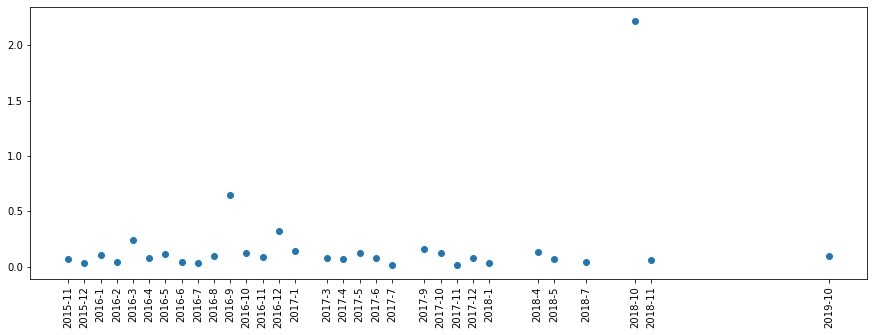

In [45]:
plt.scatter(A[:,3], A[:,0])
plt.xticks(A[:,3], dates, rotation = 'vertical')
plt.show()

### additional code

In [46]:
# probability of finding this mean compared to the entire lac
sigma = 10.65 # standard deviation lake all time
mean = 9.14 # average for the lake  all time
x  = 6.37 # average obtained at pierretes 2019.10.10
n = 191 # samples

#(1/(2*np.pi*sigma**2)**0.5)*np.e**(-(x-mean)**2/(2*sigma**2))
Z1 = (x - mean)/(sigma/n**0.5)
Z2 = (x - mean)/(sigma)
Z2

-0.26009389671361505